In [33]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [42]:
dir_ = Path('./final_pjt')
filepaths = list(dir_.glob(r'**/*'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,final_pjt/good/compose_47_good.jpeg,good
1,final_pjt/bad/compose_29_bad.jpeg,bad
2,final_pjt/bad/compose_09_bad.jpeg,bad
3,final_pjt/bad/compose_91_bad.jpeg,bad
4,final_pjt/bad/compose_124_bad.jpeg,bad


In [43]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 211

Number of different labels: 3

Labels: ['good' 'bad' 'final_pjt']


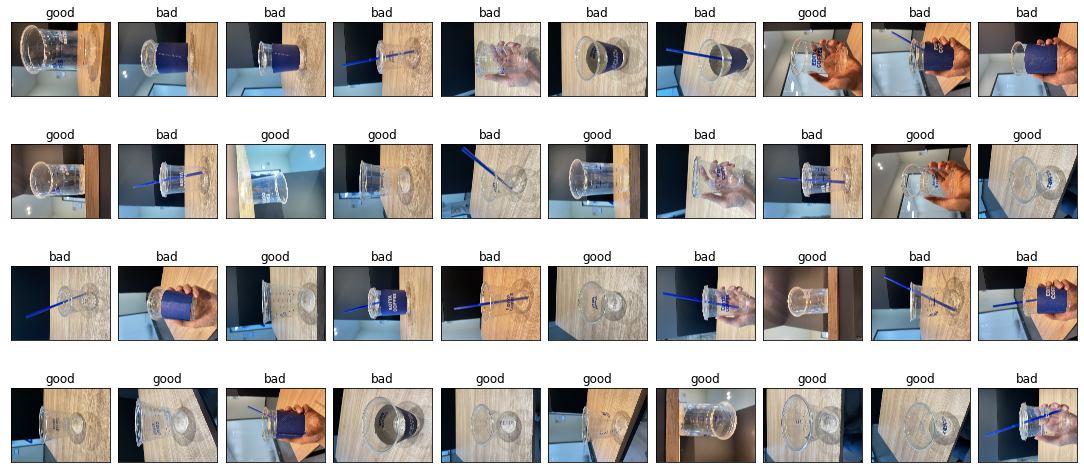

In [44]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

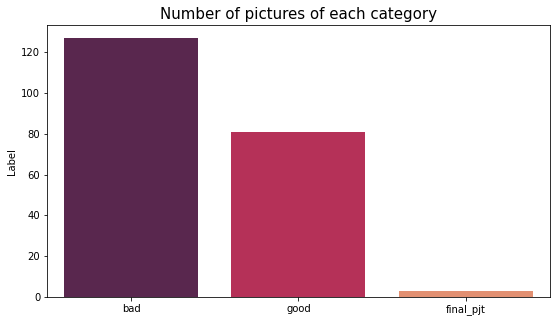

In [45]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [46]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((189, 2), (22, 2))

In [48]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('./final_pjt',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('./final_pjt',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 166 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


In [53]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [54]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)


Epoch 1/10


2022-06-03 18:21:50.417830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1652 - accuracy: 0.5482

2022-06-03 18:22:08.062527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 22s 4s/step - loss: 1.1652 - accuracy: 0.5482 - val_loss: 0.5489 - val_accuracy: 0.8293
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 0.3807 - accuracy: 0.9036 - val_loss: 0.3655 - val_accuracy: 0.8293
Epoch 3/10
6/6 [==============================] - 18s 4s/step - loss: 0.1807 - accuracy: 0.9518 - val_loss: 0.2676 - val_accuracy: 0.8780
Epoch 4/10
6/6 [==============================] - 18s 3s/step - loss: 0.1411 - accuracy: 0.9458 - val_loss: 0.1782 - val_accuracy: 0.9024
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.0796 - accuracy: 0.9518 - val_loss: 0.1952 - val_accuracy: 0.8780
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9024
Epoch 7/10
6/6 [==============================] - 19s 3s/step - loss: 0.0104 - accuracy: 0.9940 - val_loss: 0.1124 - val_accuracy: 0.9512
Epoch 8/10
6/6 [=============================

In [55]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [57]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 168 validated image filenames belonging to 2 classes.
Found 18 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.




2022-06-03 18:27:35.927312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:27:53.971149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


DenseNet121          trained in 26.65 sec
9420800/9406464 [==============================] - 1s 0us/step


2022-06-03 18:28:02.531447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:28:20.501256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


MobileNetV2          trained in 23.6 sec
74850304/74836368 [==============================] - 11s 0us/step


2022-06-03 18:28:43.793321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:29:03.954751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


DenseNet201          trained in 31.07 sec
16719872/16705208 [==============================] - 2s 0us/step


2022-06-03 18:29:16.984351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:29:35.124406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


EfficientNetB0       trained in 26.78 sec
27033600/27018416 [==============================] - 3s 0us/step


2022-06-03 18:29:48.379564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:30:07.365015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


EfficientNetB1       trained in 27.22 sec
87924736/87910968 [==============================] - 9s 0us/step


2022-06-03 18:30:25.702630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:30:44.101997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InceptionV3          trained in 25.57 sec
12697600/12683000 [==============================] - 1s 0us/step


2022-06-03 18:30:53.687241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:31:11.627372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


MobileNetV3Large     trained in 24.33 sec
234561536/234545216 [==============================] - 23s 0us/step


2022-06-03 18:31:46.990146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:32:05.641955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


ResNet152V2          trained in 29.8 sec
94781440/94765736 [==============================] - 9s 0us/step


2022-06-03 18:32:24.523337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:32:42.117920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


ResNet50             trained in 23.84 sec
94683136/94668760 [==============================] - 9s 0us/step


2022-06-03 18:32:58.198442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:33:15.644525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


ResNet50V2           trained in 23.84 sec
80150528/80134624 [==============================] - 8s 0us/step


2022-06-03 18:33:29.579399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:33:47.265448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


VGG19                trained in 22.92 sec
58900480/58889256 [==============================] - 5s 0us/step


2022-06-03 18:33:57.657735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:34:15.027113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


VGG16                trained in 22.57 sec
83697664/83683744 [==============================] - 9s 0us/step


2022-06-03 18:34:33.377049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-03 18:34:51.522740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Xception             trained in 25.82 sec


In [67]:
len(y_test)

22

In [68]:
len(pred)

21

In [71]:
test_df['Filepath']

test_df2 = test_df.drop(150, axis=0)

In [72]:
test_df2

,Filepath,Label
173,final_pjt/good/compose_19_good.jpeg,good
74,final_pjt/bad/compose_07_bad.jpeg,bad
12,final_pjt/good/compose_68_good.jpeg,good
5,final_pjt/bad/compose_01_bad.jpeg,bad
55,final_pjt/good/compose_65_good.jpeg,good
89,final_pjt/good/compose_36_good.jpeg,good
125,final_pjt/bad/compose_04_bad.jpeg,bad
194,final_pjt/bad/compose_64_bad.jpeg,bad
52,final_pjt/bad/compose_43_bad.jpeg,bad
71,final_pjt/good/compose_16_good.jpeg,good


In [73]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df2.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

**DenseNet121 has a 80.95% accuracy on the test set**


2022-06-03 19:04:26.633362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**MobileNetV2 has a 71.43% accuracy on the test set**


2022-06-03 19:04:31.737761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**DenseNet201 has a 76.19% accuracy on the test set**


2022-06-03 19:04:39.283022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**EfficientNetB0 has a 57.14% accuracy on the test set**


2022-06-03 19:04:44.458379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**EfficientNetB1 has a 57.14% accuracy on the test set**


2022-06-03 19:04:50.000546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**InceptionV3 has a 80.95% accuracy on the test set**


2022-06-03 19:04:55.898468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**MobileNetV3Large has a 76.19% accuracy on the test set**


2022-06-03 19:05:01.544124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**ResNet152V2 has a 90.48% accuracy on the test set**


2022-06-03 19:05:07.141211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**ResNet50 has a 57.14% accuracy on the test set**


2022-06-03 19:05:12.240147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**ResNet50V2 has a 85.71% accuracy on the test set**


2022-06-03 19:05:16.993293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**VGG19 has a 57.14% accuracy on the test set**


2022-06-03 19:05:21.173896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**VGG16 has a 57.14% accuracy on the test set**


2022-06-03 19:05:25.460785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**Xception has a 100.00% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,Xception,0.9444,1.0000,25.82
1,ResNet152V2,0.8889,0.9048,29.80
2,ResNet50V2,0.9444,0.8571,23.84
3,DenseNet121,0.8889,0.8095,26.65
4,InceptionV3,0.6667,0.8095,25.57
5,DenseNet201,0.8889,0.7619,31.07
6,MobileNetV3Large,0.9444,0.7619,24.33
7,MobileNetV2,0.9444,0.7143,23.60
8,EfficientNetB0,0.5556,0.5714,26.78
9,EfficientNetB1,0.5556,0.5714,27.22


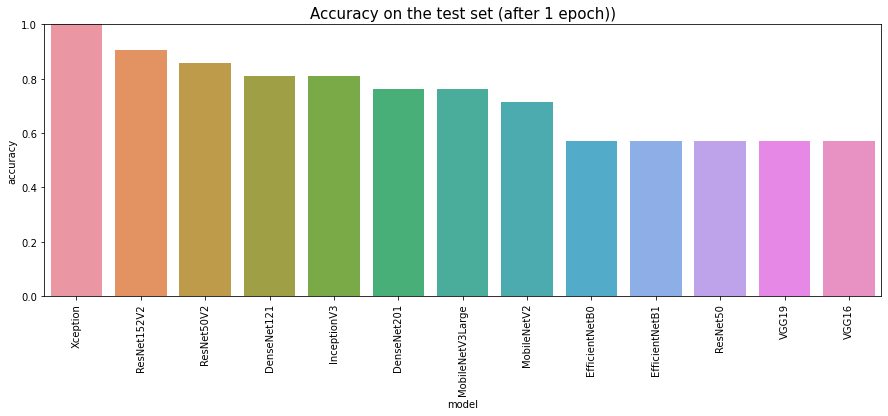

In [74]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

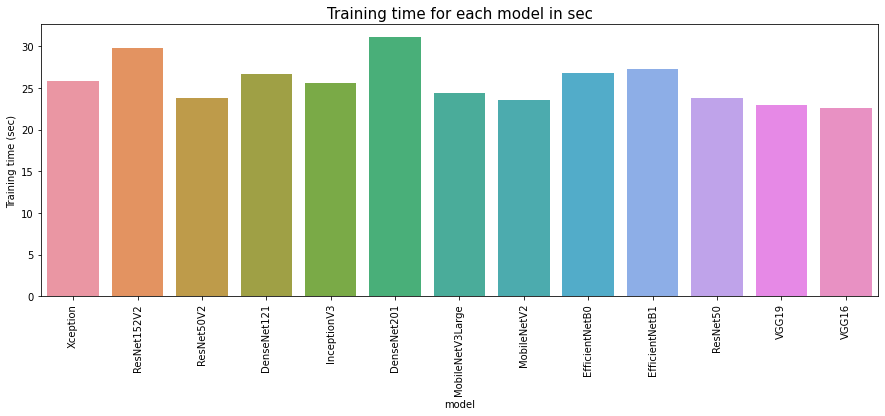

In [75]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()


In [76]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,epochs=7)

/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 168 validated image filenames belonging to 2 classes.
Found 18 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Epoch 1/7


2022-06-03 19:06:25.755788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.7560

2022-06-03 19:06:43.136284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 21s 3s/step - loss: 0.4564 - accuracy: 0.7560 - val_loss: 0.1462 - val_accuracy: 1.0000
Epoch 2/7
6/6 [==============================] - 17s 3s/step - loss: 0.1460 - accuracy: 0.9524 - val_loss: 0.0674 - val_accuracy: 1.0000
Epoch 3/7
6/6 [==============================] - 17s 3s/step - loss: 0.0560 - accuracy: 0.9940 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 4/7
6/6 [==============================] - 17s 3s/step - loss: 0.0263 - accuracy: 0.9940 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 5/7
6/6 [==============================] - 18s 3s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 6/7
6/6 [==============================] - 18s 3s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 7/7
6/6 [==============================] - 18s 3s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000


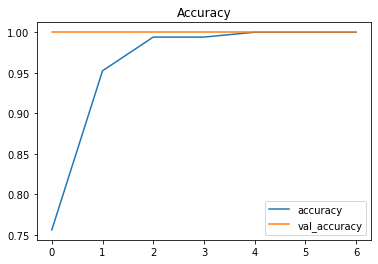

In [77]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

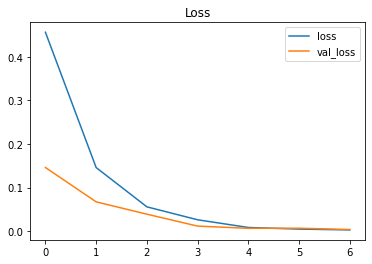

In [78]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [81]:
test_df['Filepath']

test_df2 = test_df.drop(150, axis=0)

In [82]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df2.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 100.00%


In [83]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00        12
        good       1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



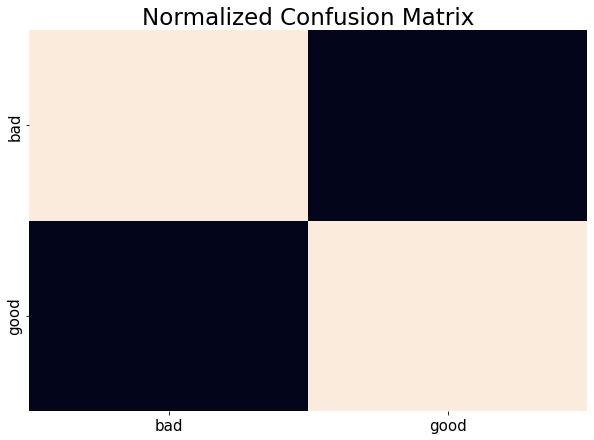

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

번호를 입력하세요 : 12


## 예측률 : 99.99%

### Class prediction = bad

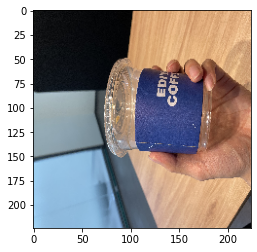

In [98]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'bad':0,
                   'good':1}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [101]:
test_df2.Filepath.iloc[1]

'final_pjt/bad/compose_07_bad.jpeg'

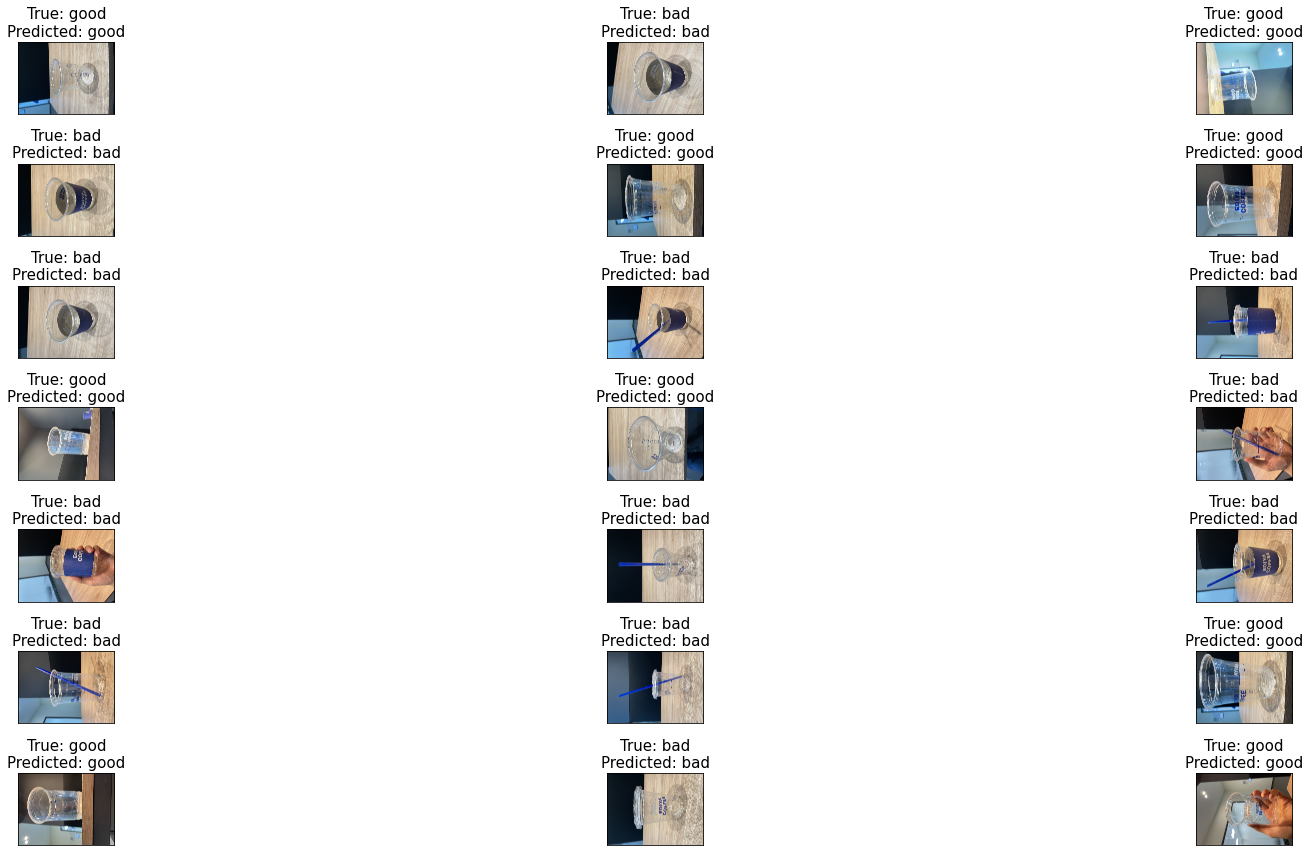

In [103]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(30, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df2.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df2.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [104]:
test_df.iloc[number_1, 0]

'final_pjt/bad/compose_37_bad.jpeg'

### Class prediction = good

[[0.016286151 0.98371387 ]]


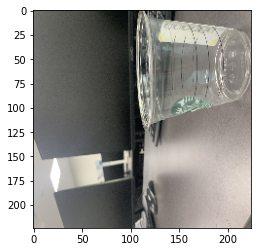

In [107]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'bad':0,
                   'good':1}
IMAGE_SIZE    = (224, 224)
# number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img('final_pjt/IMG_9009.JPG'
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
# printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

print(prediction)